# 1) Initial Test for Phase Space Plotting

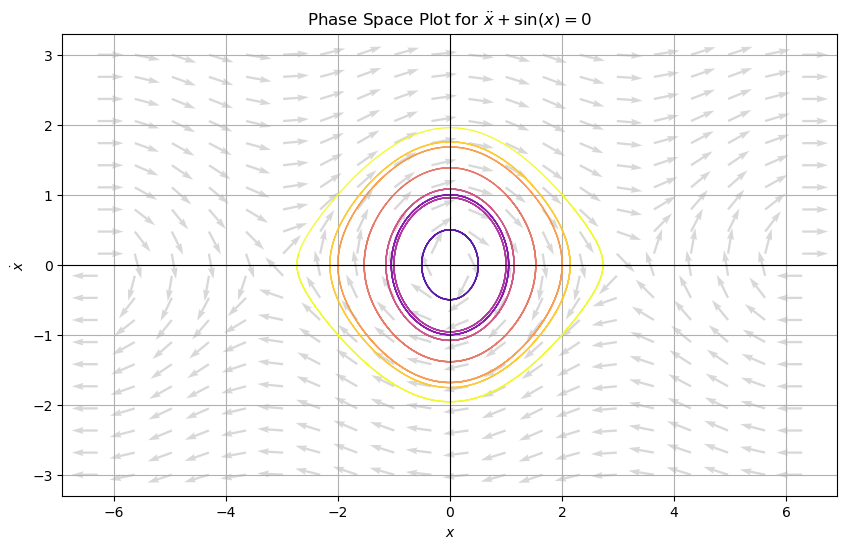

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the system of first-order ODEs
def phase_space_system(state, t):
    """
    Computes the derivatives dx/dt and d^2x/dt^2 for the system:
        dx/dt = v
        dv/dt = -sin(x)
    """
    x, v = state  # Unpack state vector
    dxdt = v
    dvdt = -np.sin(x)
    return [dxdt, dvdt]

# Create a grid for the phase-space plot
x_vals = np.linspace(-2*np.pi, 2*np.pi, 20)  # Position range
v_vals = np.linspace(-3, 3, 20)  # Velocity range
X, V = np.meshgrid(x_vals, v_vals)  # Mesh grid

# Compute the vector field
DX = V
DV = -np.sin(X)

# Normalize for uniform arrow sizes
norm = np.sqrt(DX**2 + DV**2)
DX, DV = DX/norm, DV/norm  

# Create the figure
plt.figure(figsize=(10, 6))

# Quiver plot with lighter arrows
plt.quiver(X, V, DX, DV, color='gray', alpha=0.3, scale=30)

# Solve for example trajectories in phase space
t = np.linspace(0, 20, 1000)  # Time for integration
initial_conditions = [[x0, v0] for x0 in np.linspace(0, 2, 3) for v0 in np.linspace(0,1,3)]

# Color gradient: cooler for stability, warmer for instability
colors = plt.cm.plasma(np.linspace(0, 1, len(initial_conditions)))
for idx, ic in enumerate(initial_conditions):
    sol = odeint(phase_space_system, ic, t)
    plt.plot(sol[:, 0], sol[:, 1], color=colors[idx % len(colors)], linestyle='-', linewidth=1, alpha=0.9)

# Labels and aesthetics
plt.xlabel(r"$x$")
plt.ylabel(r"$\dot{x}$")
plt.title("Phase Space Plot for $\ddot{x} + \sin(x) = 0$")
plt.axhline(0, color='black', linewidth=0.8)  # Horizontal axis
plt.axvline(0, color='black', linewidth=0.8)  # Vertical axis
plt.grid(True)
plt.show()


# 2) Modularizing and making it re-usable for any System of ODE

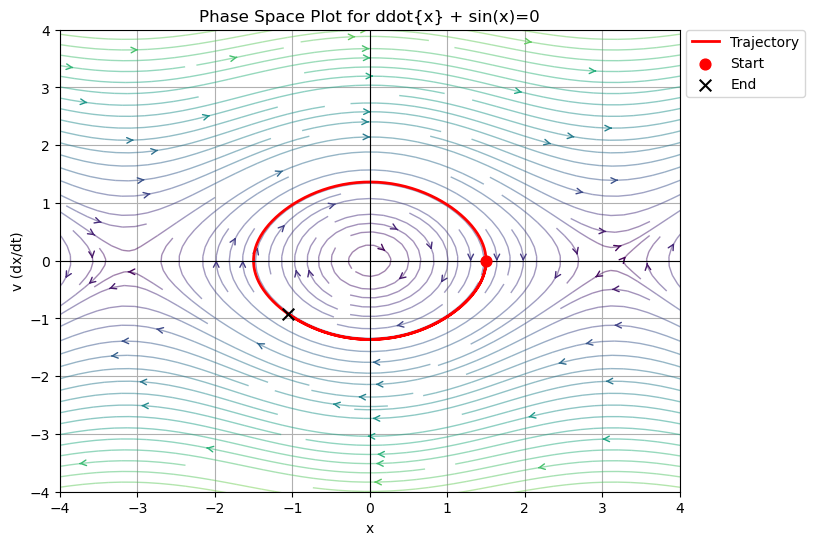

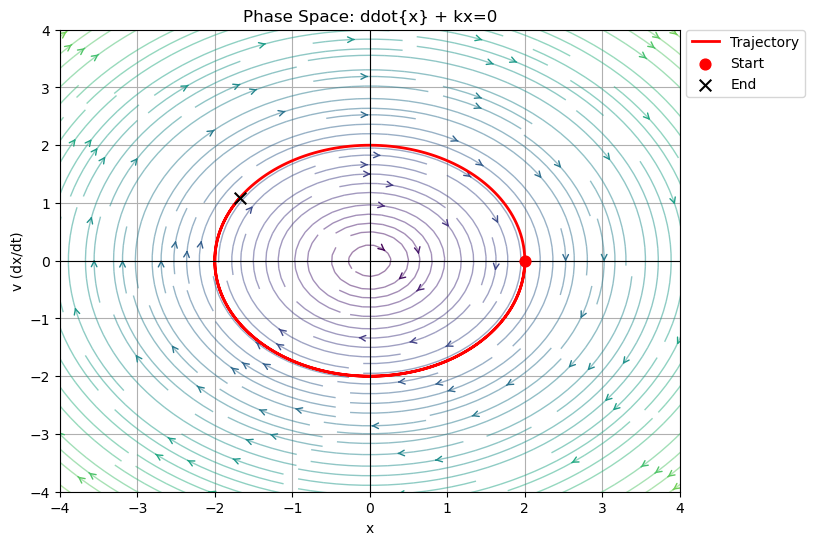

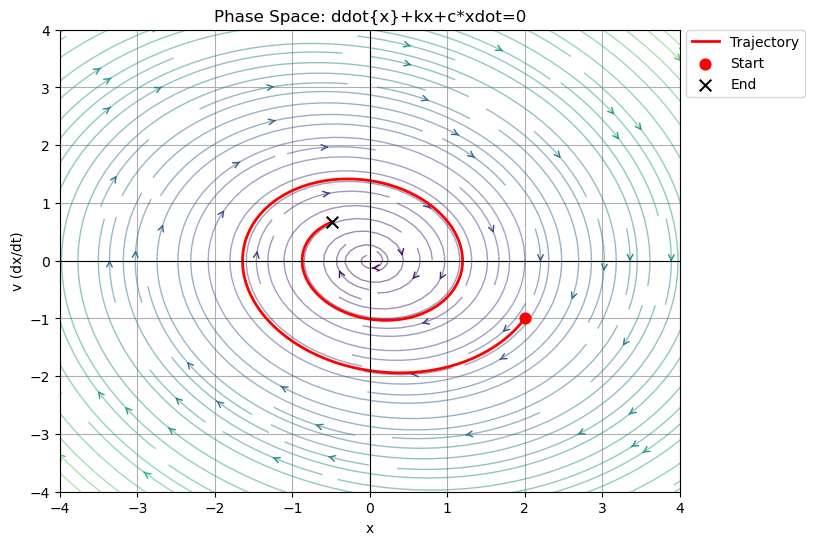

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# -----------------------------
# Example acceleration functions
# -----------------------------
def harmonic_oscillator(x, v, t, k=1.0):
    return -k * x

def damped_oscillator(x, v, t, k=1.0, c=0.1):
    return -k * x - c * v

def nonlinear_pendulum(x, v, t):
    return -np.sin(x)


def phase_space_system(state, t, acceleration_func):
    """
    Rewrites ddot{x} = f(x,v,t) as two first-order ODEs.
    state = [x, v] => returns [dx/dt, dv/dt].
    """
    x, v = state
    dxdt = v
    dvdt = acceleration_func(x, v, t)
    return [dxdt, dvdt]

def plot_phase_space(acceleration_func, x0=0.0, v0=2.0, title="Phase Space Plot"):
    """
    1) Builds a (x,v) grid, computes dx/dt = v, dv/dt = acceleration_func(...),
       then plots a streamplot (smooth flow lines).
    2) Integrates a *single* trajectory from (x0,v0) over t in [0..10],
       plots it in red with start/end markers.

    Parameters
    ----------
    acceleration_func : (x,v,t)-> ddot{x}
        E.g., harmonic_oscillator(x,v,t) or damped_oscillator(x,v,t).
    x0, v0 : float
        Initial condition for the single trajectory. 
    title : str
        Figure title.
    """
    # 1) Create a grid for (x,v)
    x_vals = np.linspace(-5, 5, 40)
    v_vals = np.linspace(-5, 5, 40)
    # 'indexing="xy"' ensures X is horizontal coords, V is vertical coords
    X, V = np.meshgrid(x_vals, v_vals, indexing='xy')  

    # 2) For each grid point, define U = dx/dt, W = dv/dt
    #    Here, dx/dt = v, dv/dt = acceleration_func(x,v,0)
    U = V.copy()             # U is "horizontal" velocity (dx/dt)
    W = np.zeros_like(X)     # W is "vertical" velocity (dv/dt)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_here = X[i,j]
            v_here = V[i,j]
            W[i,j] = acceleration_func(x_here, v_here, 0.0)

    # 3) Normalize for uniform arrow lengths
    mag = np.sqrt(U**2 + W**2)
    mag[mag == 0] = 1e-12
    U /= mag
    W /= mag

    # 4) Plot the streamlines
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("v (dx/dt)")

    strm = plt.streamplot(X, V,     # coordinate grids
                          U, W,     # velocity field
                          color=mag,
                          cmap='viridis',
                          density=2.0,
                          linewidth=1.0,
                          arrowsize=1.0,
                          arrowstyle='->')
    strm.lines.set_alpha(0.5)

    # 5) Integrate one trajectory from (x0, v0), t in [0..10]
    t_span = np.linspace(0, 10, 300)
    ic = [x0, v0]
    sol = odeint(phase_space_system, ic, t_span, args=(acceleration_func,))

    # 6) Plot the single solution in red
    plt.plot(sol[:,0], sol[:,1], color='red', linewidth=2, label="Trajectory")

    # Mark start/end
    plt.scatter(sol[0,0],  sol[0,1],  color='red', marker='o', s=60, zorder=3, label="Start")
    plt.scatter(sol[-1,0], sol[-1,1], color='black', marker='x', s=70, zorder=3, label="End")

    # 7) Tidy up
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.0)
    plt.show()

# -----------------------------
# Demo usage
# -----------------------------
if __name__ == "__main__":
    # 1) Nonlinear Pendulum
    plot_phase_space(nonlinear_pendulum,
                     x0=1.5, v0=0.0,
                     title="Phase Space Plot for ddot{x} + sin(x)=0")

    # 2) Harmonic Oscillator
    plot_phase_space(harmonic_oscillator,
                     x0=2.0, v0=0.0,
                     title="Phase Space: ddot{x} + kx=0")

    # 3) Damped Oscillator
    #    e.g. ddot{x} = -k*x - c*v with k=1, c=0.2
    damped = lambda x,v,t: damped_oscillator(x,v,t,k=1.0,c=0.2)
    plot_phase_space(damped,
                     x0=2.0, v0=-1.0,
                     title="Phase Space: ddot{x}+kx+c*xdot=0")


# 3) Phase Space Plots for Duffing Equation and Numerical Check

=== Axis 1 Undamped Duffing Setup ===
Initial w_dot_1(0) = +0.600000
A=-2.350000, B=+2.000000, K=-0.990000

Numeric check: LHS-K remains within ±1e-10 over t in [0,5]. Good!



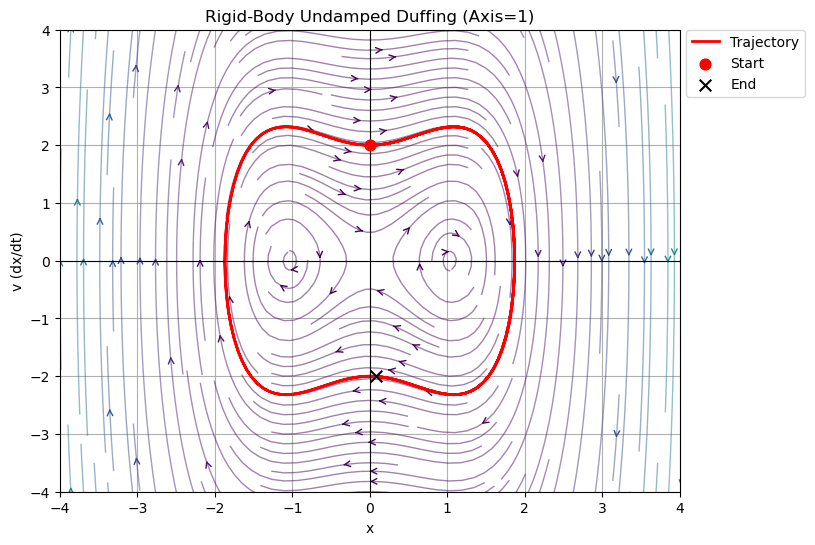

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

def undamped_duffing_ode(I, omega_init, axis=1, tolerance=1e-12):
    """
    Builds an undamped Duffing acceleration function for a chosen principal axis,
    incorporating initial angular acceleration from torque-free Euler eqns.

    Parameters
    ----------
    I : (I1, I2, I3)
        Principal moments of inertia.
    omega_init : (w1_0, w2_0, w3_0)
        Initial body rates in principal axes.
    axis : int, default=1
        Which axis to treat as the 1D Duffing oscillator (1, 2, or 3).
    tolerance : float, default=1e-6
        Tolerance for numeric check of LHS-K matching.

    Returns
    -------
    acceleration_func : callable
        A function accel(x, v, t) -> ddx/dt^2 = -A*x - B*x^3
        suitable for use with plot_phase_space(...).

    Notes
    -----
    1) We compute the initial *angular acceleration* w_dot_i(0) from
       torque-free Euler eqns:
         w1_dot = ((I2 - I3)*w2*w3)/I1, etc.
    2) We do a short "energy check" to confirm LHS(t) is near K, 
       printing only if the difference exceeds 'tolerance'.
    """
    I1, I2, I3 = I
    w1_0, w2_0, w3_0 = omega_init

    # --------------------------------------------------
    #  A) Compute the initial angular accelerations from 
    #     torque-free Euler eqns
    # --------------------------------------------------
    w1_dot_0 = ((I2 - I3)*w2_0*w3_0)/I1
    w2_dot_0 = ((I3 - I1)*w3_0*w1_0)/I2
    w3_dot_0 = ((I1 - I2)*w1_0*w2_0)/I3

    # --------------------------------------------------
    #  B) Compute H^2, T from initial conditions
    # --------------------------------------------------
    H_sq = (I1*w1_0)**2 + (I2*w2_0)**2 + (I3*w3_0)**2
    T    = 0.5*(I1*w1_0**2 + I2*w2_0**2 + I3*w3_0**2)

    # --------------------------------------------------
    #  C) Derive A_i, B_i, K_i for the chosen axis
    # --------------------------------------------------
    if axis == 1:
        # Axis 1
        A = ((I1 - I2)*(2*I3*T - H_sq) + (I1 - I3)*(2*I2*T - H_sq)) / (I1*I2*I3)
        B = (2*(I1 - I2)*(I1 - I3)) / (I2*I3)
        K = ((2*I2*T - H_sq)*(H_sq - 2*I3*T)) / (I1**2 * I2 * I3)
        # We'll use initial (x, xdot) = (w1_0, w1_dot_0)
        x0 = w1_0
        xdot0 = w1_dot_0
    elif axis == 2:
        # Axis 2
        A = ((I2 - I3)*(2*I1*T - H_sq) + (I2 - I1)*(2*I3*T - H_sq)) / (I1*I2*I3)
        B = (2*(I2 - I1)*(I2 - I3)) / (I1*I3)
        K = ((2*I3*T - H_sq)*(H_sq - 2*I1*T)) / (I1 * I2**2 * I3)
        x0 = w2_0
        xdot0 = w2_dot_0
    else:
        # Axis 3
        A = ((I3 - I1)*(2*I2*T - H_sq) + (I3 - I2)*(2*I1*T - H_sq)) / (I1*I2*I3)
        B = (2*(I3 - I1)*(I3 - I2)) / (I1*I2)
        K = ((2*I1*T - H_sq)*(H_sq - 2*I2*T)) / (I1 * I2 * I3**2)
        x0 = w3_0
        xdot0 = w3_dot_0

    print(f"=== Axis {axis} Undamped Duffing Setup ===")
    print(f"Initial w_dot_{axis}(0) = {xdot0:+.6f}")
    print(f"A={A:+.6f}, B={B:+.6f}, K={K:+.6f}\n")

    # --------------------------------------------------
    #  D) Build the "acceleration_func(x, v, t)"
    #     needed by plot_phase_space(...).
    #     ddx/dt^2 = -A*x - B*x^3
    # --------------------------------------------------
    def acceleration_func(x, v, t):
        return -A*x - B*(x**3)

    # --------------------------------------------------
    #  E) (Optional) Numeric check over a short time:
    #     We'll integrate from [x(0)=x0, xdot(0)=xdot0] 
    #     for e.g. t in [0, 5].
    #     Then compare "LHS(t)=v^2 + A x^2 + 0.5 B x^4" to K.
    # --------------------------------------------------
    # 1D ODE: 
    #   y = [x, v],  dy/dt = [ v,  -A*x - B*x^3 ]
    # We'll only print if difference > tolerance
    t_test = np.linspace(0, 5, 201)
    def duffing_1d_ode(t, y):
        return [ y[1], acceleration_func(y[0], y[1], t) ]

    from functools import partial
    from scipy.integrate import solve_ivp
    sol = solve_ivp(
        duffing_1d_ode, (0,5), [x0, xdot0], t_eval=t_test,
        rtol=1e-12, atol=1e-12
    )

    has_violations = False
    for (ti, xi, vi) in zip(sol.t, sol.y[0], sol.y[1]):
        lhs = vi**2 + A*(xi**2) + 0.5*B*(xi**4)
        diff = abs(lhs - K)
        if diff > tolerance:
            print(f" LHS-K at t={ti:.2f} => {lhs-K:+.3e} (exceeds tol={tolerance})")
            has_violations = True
            # If you want to stop checking at first violation, 
            # break or continue as you wish.

    if not has_violations:
        print(f"Numeric check: LHS-K remains within ±{tolerance} over t in [0,5]. Good!\n")

    # Return the acceleration_func so it can be used in plot_phase_space(...)
    return acceleration_func

if __name__ == "__main__":
    I_values = [5.0, 3.0, 2.0]
    omega_init = [1.0, 2.0, 1.5]

    # Build the acceleration function for axis=1, say
    accel_func_axis1 = undamped_duffing_ode(I_values, omega_init, axis=1, tolerance=1e-10)

    # Plot the phase space using that function
    plot_phase_space(accel_func_axis1, title="Rigid-Body Undamped Duffing (Axis=1)")

# 4) Modularizing better?

=== Precomputed (A_i, B_i, K_i) for Each Axis ===
A1=-2.350000, A2=3.050000, A3=-0.700000
B1=2.000000, B2=-0.400000, B3=0.400000
K1=-0.990000, K2=+11.250000, K3=+3.437500

=== Numeric Check for LHS_i(t) vs. K_i (Separate Axes) ===
Check at multiples of 1.00 seconds up to t=10

--- t=0.000 ---
Axis1: x1(t)=+1.000000, v1(t)=+0.600000, LHS1=-9.900000e-01, LHS1-K1=+0.00e+00
Axis2: x2(t)=+2.000000, v2(t)=-1.500000, LHS2=+1.125000e+01, LHS2-K2=+0.00e+00
Axis3: x3(t)=+1.500000, v3(t)=+2.000000, LHS3=+3.437500e+00, LHS3-K3=+0.00e+00

--- t=1.000 ---
Axis1: x1(t)=+1.297452, v1(t)=-0.363555, LHS1=-9.900000e-01, LHS1-K1=+8.16e-13
Axis2: x2(t)=-0.763601, v2(t)=-3.088622, LHS2=+1.125000e+01, LHS2-K2=-1.04e-10
Axis3: x3(t)=+2.380528, v3(t)=-0.990736, LHS3=+3.437500e+00, LHS3-K3=+3.49e-12

--- t=2.000 ---
Axis1: x1(t)=+0.784862, v1(t)=-0.279561, LHS1=-9.900000e-01, LHS1-K1=+3.16e-12
Axis2: x2(t)=-2.433096, v2(t)=-0.450900, LHS2=+1.125000e+01, LHS2-K2=-9.74e-11
Axis3: x3(t)=+0.574496, v3(t)=-1.909645,

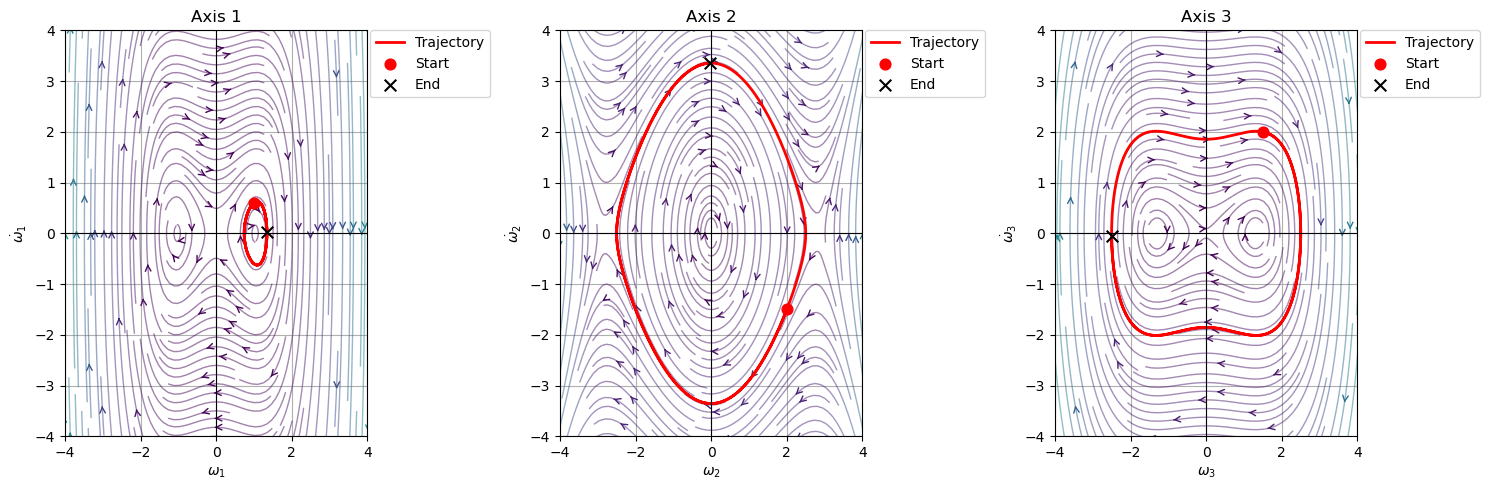

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def integrate_ode(acceleration_func, x0, v0, timespan, method="LSODA"):
    """
    Integrate a 1D second-order ODE ddot{x} = acceleration_func(x, v, t)
    over [0, timespan]. Returns a solve_ivp solution with high resolution.
    """
    def ode_system(t, y):
        # State is [x,v]. Derivatives are [v, acceleration(x,v,t)].
        return [y[1], acceleration_func(y[0], y[1], t)]

    # Dense time array for solution storage
    t_eval = np.linspace(0, timespan, 5000)

    sol = solve_ivp(ode_system, (0, timespan), [x0, v0], t_eval=t_eval, method=method, rtol=1e-12, atol=1e-14)
    
    return sol

def undamped_duffing_ode(I, omega_init, axis=1, tolerance=1e-12):
    """
    Construct an undamped Duffing acceleration function for a chosen axis.
    Uses Euler eqns to find initial angular acceleration. Returns (func, x0, v0, K).
    """
    I1, I2, I3 = I
    w1_0, w2_0, w3_0 = omega_init

    # Compute initial angular accelerations from Euler eqns
    w1_dot_0 = ((I2 - I3)*w2_0*w3_0)/I1
    w2_dot_0 = ((I3 - I1)*w3_0*w1_0)/I2
    w3_dot_0 = ((I1 - I2)*w1_0*w2_0)/I3

    # Compute H^2 and T
    H_sq = (I1*w1_0)**2 + (I2*w2_0)**2 + (I3*w3_0)**2
    T    = 0.5*(I1*w1_0**2 + I2*w2_0**2 + I3*w3_0**2)

    # Axis-specific A,B and Initial x0, v0
    if axis==1:
        A = ((I1 - I2)*(2*I3*T - H_sq) + (I1 - I3)*(2*I2*T - H_sq)) / (I1*I2*I3)
        B = (2*(I1 - I2)*(I1 - I3)) / (I2*I3)
        x0, v0 = w1_0, w1_dot_0
    elif axis==2:
        A = ((I2 - I3)*(2*I1*T - H_sq) + (I2 - I1)*(2*I3*T - H_sq)) / (I1*I2*I3)
        B = (2*(I2 - I1)*(I2 - I3)) / (I1*I3)
        x0, v0 = w2_0, w2_dot_0
    else:
        A = ((I3 - I1)*(2*I2*T - H_sq) + (I3 - I2)*(2*I1*T - H_sq)) / (I1*I2*I3)
        B = (2*(I3 - I1)*(I3 - I2)) / (I1*I2)
        x0, v0 = w3_0, w3_dot_0

    # Build K for each axis but select only one
    K1 = ((2*I2*T - H_sq)*(H_sq - 2*I3*T)) / (I1**2*I2*I3)
    K2 = ((2*I3*T - H_sq)*(H_sq - 2*I1*T)) / (I1*I2**2 * I3)
    K3 = ((2*I1*T - H_sq)*(H_sq - 2*I2*T)) / (I1*I2 * I3**2)
    K = (K1 if axis == 1 else K2) if axis < 3 else K3

    print(f"=== Duffing Setup for Axis={axis} ===")
    print(f"Initial w_dot_{axis}(0)={v0:+.6f},  A={A:+.6f},  B={B:+.6f},  K={K:+.6f}\n")

    # define the final “acceleration_func”
    def acceleration_func(x, v, t):
        return -A*x - B*(x**3)

    return acceleration_func, x0, v0, K

def track_mismatch_solve_ivp(I, omega_init, t_end=20.0, dt=0.001, check_interval=1.0):
    """
    Treat each axis as a separate Nonlinear Duffing oscillator. Integrate and verify
    LHS_i(t) = v_i^2 + A_i*x_i^2 + (B_i/2)*x_i^4 vs. K_i at chosen intervals.
    """
    I1, I2, I3 = I
    w1_0, w2_0, w3_0 = omega_init

    # Initial angular accelerations from Euler eqns
    w1_dot_0 = ((I2 - I3)*w2_0*w3_0)/I1
    w2_dot_0 = ((I3 - I1)*w3_0*w1_0)/I2
    w3_dot_0 = ((I1 - I2)*w1_0*w2_0)/I3

    # Compute H^2 and T
    H_sq = (I1*w1_0)**2 + (I2*w2_0)**2 + (I3*w3_0)**2
    T = 0.5*(I1*(w1_0**2) + I2*(w2_0**2) + I3*(w3_0**2))

    # 3) A_i,B_i,K_i for each axis
    A1 = ((I1 - I2)*(2*I3*T - H_sq) + (I1 - I3)*(2*I2*T - H_sq)) / (I1*I2*I3)
    A2 = ((I2 - I3)*(2*I1*T - H_sq) + (I2 - I1)*(2*I3*T - H_sq)) / (I1*I2*I3)
    A3 = ((I3 - I1)*(2*I2*T - H_sq) + (I3 - I2)*(2*I1*T - H_sq)) / (I1*I2*I3)

    B1 = (2*(I1 - I2)*(I1 - I3)) / (I2*I3)
    B2 = (2*(I2 - I1)*(I2 - I3)) / (I1*I3)
    B3 = (2*(I3 - I1)*(I3 - I2)) / (I1*I2)

    K1 = ((2*I2*T - H_sq)*(H_sq - 2*I3*T)) / (I1**2*I2*I3)
    K2 = ((2*I3*T - H_sq)*(H_sq - 2*I1*T)) / (I1*I2**2 * I3)
    K3 = ((2*I1*T - H_sq)*(H_sq - 2*I2*T)) / (I1*I2 * I3**2)

    print("=== Precomputed (A_i, B_i, K_i) for Each Axis ===")
    print(f"A1={A1:.6f}, A2={A2:.6f}, A3={A3:.6f}")
    print(f"B1={B1:.6f}, B2={B2:.6f}, B3={B3:.6f}")
    print(f"K1={K1:+.6f}, K2={K2:+.6f}, K3={K3:+.6f}\n")

    # Integrate each axis's Duffing ODE
    sol1 = integrate_ode(lambda x,v,t: -A1*x - B1*x**3, w1_0, w1_dot_0, t_end)
    sol2 = integrate_ode(lambda x,v,t: -A2*x - B2*x**3, w2_0, w2_dot_0, t_end)
    sol3 = integrate_ode(lambda x,v,t: -A3*x - B3*x**3, w3_0, w3_dot_0, t_end)

    # Parse Thru sol object
    t_array = sol1.t
    x1_array, v1_array = sol1.y
    x2_array, v2_array = sol2.y
    x3_array, v3_array = sol3.y

    print("=== Numeric Check for LHS_i(t) vs. K_i (Separate Axes) ===")
    print(f"Check at multiples of {check_interval:.2f} seconds up to t={t_end}\n")

    # 6) Evaluate LHS_i(t) = v_i^2 + A_i*x_i^2 + 0.5*B_i*x_i^4
    next_print_time = 0.0
    small_tol = 1e-10

    for i, t_now in enumerate(t_array):
        while t_now >= next_print_time - small_tol:
            x1, v1 = x1_array[i], v1_array[i]
            x2, v2 = x2_array[i], v2_array[i]
            x3, v3 = x3_array[i], v3_array[i]

            lhs1 = v1**2 + A1*(x1**2) + 0.5*B1*(x1**4)
            lhs2 = v2**2 + A2*(x2**2) + 0.5*B2*(x2**4)
            lhs3 = v3**2 + A3*(x3**2) + 0.5*B3*(x3**4)

            diff1 = lhs1 - K1
            diff2 = lhs2 - K2
            diff3 = lhs3 - K3

            print(f"--- t={t_now:.3f} ---")
            print(f"Axis1: x1(t)={x1:+.6f}, v1(t)={v1:+.6f}, LHS1={lhs1:+.6e}, LHS1-K1={diff1:+.2e}")
            print(f"Axis2: x2(t)={x2:+.6f}, v2(t)={v2:+.6f}, LHS2={lhs2:+.6e}, LHS2-K2={diff2:+.2e}")
            print(f"Axis3: x3(t)={x3:+.6f}, v3(t)={v3:+.6f}, LHS3={lhs3:+.6e}, LHS3-K3={diff3:+.2e}\n")

            next_print_time += check_interval

    print("...Done.\n")


def phase_space_plotter(sol, acceleration_func, xlabel="x", ylabel="v", title="Phase Space Plot", ax=None):
    """
    Plot a phase space with streamlines and a single red trajectory.
    """
    # Create a grid for (x, v)
    x_vals = np.linspace(-5, 5, 40)
    v_vals = np.linspace(-5, 5, 40)
    X, V = np.meshgrid(x_vals, v_vals, indexing='xy')

    # Compute the vecotr field based on accelration function
    U = V.copy()
    W = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            W[i, j] = acceleration_func(X[i, j], V[i, j], 0.0)

    # Normalize arrow lengths
    mag = np.sqrt(U**2 + W**2)
    mag[mag == 0] = 1e-12
    U /= mag
    W /= mag

    # Use provided axis for subplot or create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    strm = ax.streamplot(X, V, U, W, 
                         color=mag, 
                         cmap='viridis', 
                         density=2.0, 
                         linewidth=1.0, 
                         arrowsize=1.0, 
                         arrowstyle='->')
    strm.lines.set_alpha(0.5)

    # Plot the integrated trajectory
    ax.plot(sol.y[0], sol.y[1], color='red', linewidth=2, label="Trajectory")

    # Mark start/end points
    ax.scatter(sol.y[0, 0], sol.y[1, 0], color='red', marker='o', s=60, zorder=3, label="Start")
    ax.scatter(sol.y[0, -1], sol.y[1, -1], color='black', marker='x', s=70, zorder=3, label="End")

    # Formatting and styling
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.0)

    # Show figure only if ax is None
    if ax is None:
        plt.show()


if __name__ == "__main__":
    # Define system parameters
    I_values = [5.0, 3.0, 2.0]
    omega_init = [1.0, 2.0, 1.5]
    timespan = 10

    # Perform numerical check
    track_mismatch_solve_ivp(I_values, omega_init, t_end=timespan, dt = 0.01, check_interval=1.0)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    # Loop over each principal axis
    for axis_idx, ax in enumerate(axs, start=1):
        
        # Build the Duffing for this axis
        accel_func, x0, v0, _ = undamped_duffing_ode(I_values, omega_init, axis=axis_idx)
        
        # Integrate
        sol = integrate_ode(accel_func, x0, v0, timespan)

        # Plot into the chosen subplot
        # We'll label each with "Axis 1/2/3"
        phase_space_plotter(sol, accel_func, xlabel=f"$\\omega_{{{axis_idx}}}$", ylabel=f"$\\dot{{\\omega}}_{{{axis_idx}}}$", title=f"Axis {axis_idx}", ax=ax)

plt.tight_layout()
plt.show()